# 코드설명(임시)

- 출력 Mask 시각화
- 앞/끝과정 제외하고 source_embed + crop_frames_list로만 생성자 실행하기

In [1]:
import tqdm

def nop(it, *a, **k):
    return it

real_tqdm = tqdm.tqdm
tqdm.tqdm = nop

import pickle
import cv2
import torch
import time
import os
import glob

import numpy as np
np.bool = np.bool_

from utils.inference.faceshifter_run import faceshifter_batch
from utils.inference.image_processing import crop_face, get_final_image, show_images, normalize_and_torch, normalize_and_torch_batch
from utils.inference.video_processing import read_video, get_target, get_final_video, add_audio_from_another_video, face_enhancement, crop_frames_and_get_transforms, resize_frames
from utils.inference.core import model_inference, transform_target_to_torch

from network.AEI_Net import AEI_Net
from coordinate_reg.image_infer import Handler
from insightface_func.face_detect_crop_multi import Face_detect_crop
from arcface_model.iresnet import iresnet100
from models.pix2pix_model import Pix2PixModel
from models.config_sr import TestOptions

#os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/kornia/augmentation/augmentation.py:1830: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  warnings.warn(


/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/mxnet/numpy/fallback.py:143: DeprecationWarning: In accordance with NEP 32, the function mirr was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financial
  mirr = onp.mirr
/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/mxnet/numpy/fallback.py:160: DeprecationWarning: In accordance with NEP 32, the function npv was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/numpy-financial
  npv = onp.npv
/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/mxnet/numpy/fallback.py:164: DeprecationWarning: In accordance with NEP 32, the function pmt was removed from NumPy version 1.20.  A replacement for this function is available in the numpy_financial library: https://pypi.org/project/

### Load Models

In [2]:
app = Face_detect_crop(name='antelope', root='./insightface_func/models')
app.prepare(ctx_id= 0, det_thresh=0.6, det_size=(640,640))

# main model for generation
G = AEI_Net(backbone='unet', num_blocks=2, c_id=512)
G.eval()
G.load_state_dict(torch.load('weights/G_unet_2blocks.pth', map_location=torch.device('cpu')))
G = G.cuda()
G = G.half()

# arcface model to get face embedding
netArc = iresnet100(fp16=False)
netArc.load_state_dict(torch.load('arcface_model/backbone.pth'))
netArc=netArc.cuda()
netArc.eval()

# model to get face landmarks
handler = Handler('./coordinate_reg/model/2d106det', 0, ctx_id=0, det_size=640)

# model to make superres of face, set use_sr=True if you want to use super resolution or use_sr=False if you don't
use_sr = True
if use_sr:
    os.environ['CUDA_VISIBLE_DEVICES'] = '0'
    torch.backends.cudnn.benchmark = True
    opt = TestOptions()
    #opt.which_epoch ='10_7'
    model = Pix2PixModel(opt)
    model.netG.train()

input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)
loading ./coordinate_reg/model/2d106det 0
input mean and std: 127.5 127.5
find model: ./insightface_func/models/antelope/glintr100.onnx recognition
find model: ./insightface_func/models/antelope/scrfd_10g_bnkps.onnx detection
set det-size: (640, 640)


[07:20:00] ../src/nnvm/legacy_json_util.cc:208: Loading symbol saved by previous version v1.5.0. Attempting to upgrade...
[07:20:00] ../src/nnvm/legacy_json_util.cc:216: Symbol successfully upgraded!
[07:20:00] ../src/base.cc:79: cuDNN lib mismatch: linked-against version 8204 != compiled-against version 8101.  Set MXNET_CUDNN_LIB_CHECKING=0 to quiet this warning.


Network [LIPSPADEGenerator] was created. Total number of parameters: 72.2 million. To see the architecture, do print(network).
Load checkpoint from path:  weights/10_net_G.pth


### Set here path to source image and video for faceswap

In [3]:
image_to_image = False

In [4]:
"""
choose not really long videos, coz it can take a lot of time othervise 
choose source image as a photo -- preferable a selfie of a person
"""
if image_to_image:
    path_to_target = 'examples/images/beckham.jpg'
else:
    #path_to_video = 'examples/videos/random_gif.gif'
    path_to_video = "examples/videos/01__hugging_happy.mp4"
#source_full = cv2.imread('examples/images/elon_musk.jpg')
source_full = cv2.imread('examples/images/Bob-Ross.webp')
OUT_VIDEO_NAME = "examples/results/result_tmp.mp4"
crop_size = 224 # don't change this
BS = 60

In [22]:
# check, if we can detect face on the source image
from utils.inference.video_processing import smooth_landmarks

kps = app.get(source_full, crop_size)
print(kps[0])
smooth_kps = smooth_landmarks([kps], n=2)
print(smooth_kps[0])
from insightface.utils import face_align
M, _ = face_align.estimate_norm(kps[0], crop_size, mode ='None') 
align_img = cv2.warpAffine(source_full, M, (crop_size,crop_size), borderValue=0.0)

source = [align_img]
"""
try:    
    source = crop_face(source_full, app, crop_size)[0]
    print(source.shape)
    source = [source[:, :, ::-1]]
    print("Everything is ok!")
except TypeError:
    print("Bad source images")
"""

[[391.75552 277.68057]
 [457.62897 245.26172]
 [468.77573 315.0874 ]
 [399.43884 374.28156]
 [458.9877  351.1417 ]]
[array([[391.75552, 277.68057],
       [457.62897, 245.26172],
       [468.77573, 315.0874 ],
       [399.43884, 374.28156],
       [458.9877 , 351.1417 ]], dtype=float32)]


'\ntry:    \n    source = crop_face(source_full, app, crop_size)[0]\n    print(source.shape)\n    source = [source[:, :, ::-1]]\n    print("Everything is ok!")\nexcept TypeError:\n    print("Bad source images")\n'

In [23]:
# read video and find target image in the video that contains at least 1 face

if image_to_image:
    target_full = cv2.imread(path_to_target)
    full_frames = [target_full]
else:
    full_frames, fps = read_video(path_to_video)
target = get_target(full_frames, app, crop_size)

### Model Inference Visualization

In [24]:
START_TIME = time.time()

In [25]:
final_frames_list, crop_frames_list, full_frames, tfm_array_list = model_inference(full_frames,
                                                                                   source,
                                                                                   target,
                                                                                   netArc,
                                                                                   G,
                                                                                   app,
                                                                                   set_target = False,
                                                                                   crop_size=crop_size,
                                                                                   BS=BS)

1
1
(256, 256, 3)


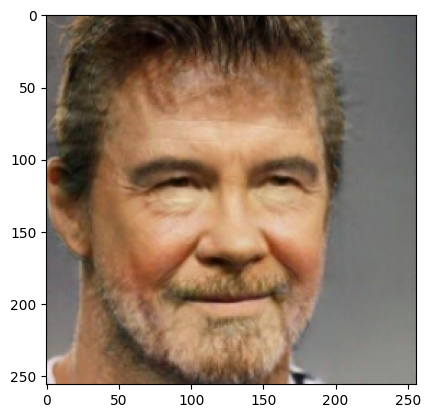

In [26]:
print(len(final_frames_list))
print(len(final_frames_list[0]))
print(final_frames_list[0][0].shape)

for frame in final_frames_list[0][:90:30]:
    if np.any(frame):
        plt.imshow(frame[:,:,::-1])
        plt.show()

In [27]:
if use_sr:
    final_frames_list = face_enhancement(final_frames_list, model)

1
1
(256, 256, 3)


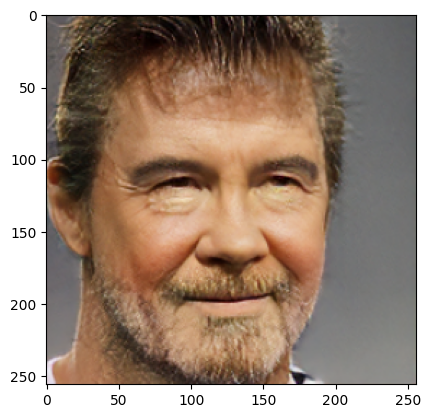

In [28]:
print(len(final_frames_list))
print(len(final_frames_list[0]))
print(final_frames_list[0][0].shape)

for frame in final_frames_list[0][:30:90]:
    if np.any(frame):
        plt.imshow(frame[:,:,::-1])
        plt.show()

In [29]:
result = get_final_image([final_frames_list[0][:1]], [crop_frames_list[0][:1]], full_frames[0], [tfm_array_list[0][:1]], handler)

/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/mxnet/ndarray/utils.py:141: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if spsp is not None and isinstance(source_array, spsp.csr.csr_matrix):
/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/mxnet/ndarray/utils.py:141: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if spsp is not None and isinstance(source_array, spsp.csr.csr_matrix):


# tgt landmark 찍기 + 마스크 시각화

In [30]:
from utils.inference.masks import face_mask_static
frame = cv2.resize(final_frames_list[0][0], (224, 224))
landmarks = handler.get_without_detection_without_transform(frame)
landmarks_tgt = handler.get_without_detection_without_transform(crop_frames_list[0][0])

mask, _ = face_mask_static(crop_frames_list[0][0], landmarks, landmarks_tgt, None)

/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/mxnet/ndarray/utils.py:141: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if spsp is not None and isinstance(source_array, spsp.csr.csr_matrix):
/compuworks/anaconda3/envs/xaiseung_ghost_cuda114/lib/python3.9/site-packages/mxnet/ndarray/utils.py:141: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  if spsp is not None and isinstance(source_array, spsp.csr.csr_matrix):


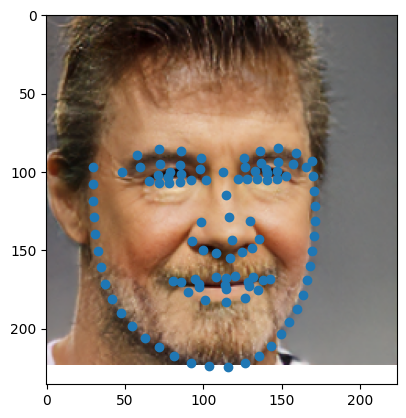

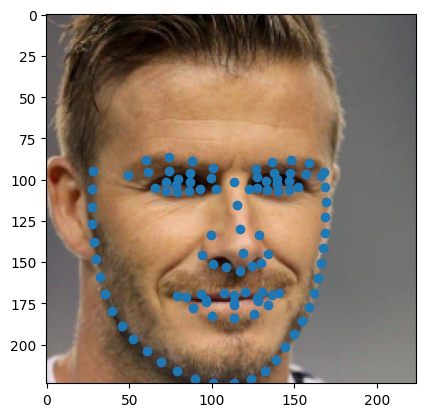

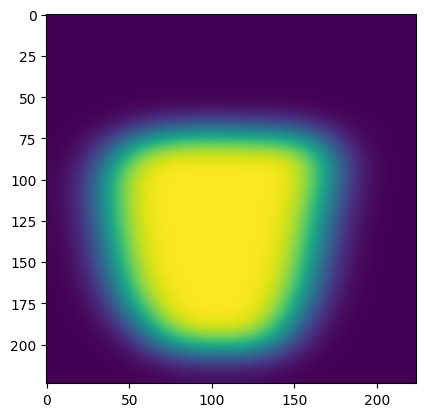

In [31]:
plt.imshow(frame[:,:,::-1])
plt.scatter(landmarks[:,0],landmarks[:, 1])
plt.show()


plt.imshow(crop_frames_list[0][0][:,:,::-1])
plt.scatter(landmarks_tgt[:,0],landmarks_tgt[:, 1])
plt.show()

plt.imshow(mask)
plt.show()

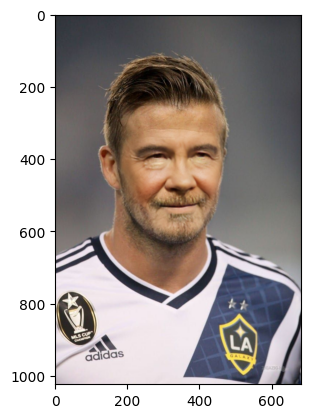

In [32]:
plt.imshow(result[:, :, ::-1])
plt.show()

In [33]:
image_to_image = True
"""
choose not really long videos, coz it can take a lot of time othervise 
choose source image as a photo -- preferable a selfie of a person
"""
if image_to_image:
    path_to_target = 'examples/images/beckham.jpg'
else:
    #path_to_video = 'examples/videos/random_gif.gif'
    path_to_video = "examples/videos/01__hugging_happy.mp4"
#source_full = cv2.imread('examples/images/elon_musk.jpg')
source_full = cv2.imread('examples/images/Bob-Ross.webp')
OUT_VIDEO_NAME = "examples/results/result_tmp.mp4"
crop_size = 224 # don't change this
BS = 60
# check, if we can detect face on the source image

try:    
    source = crop_face(source_full, app, crop_size)[0]
    print(source.shape)
    source = [source[:, :, ::-1]]
    print("Everything is ok!")
except TypeError:
    print("Bad source images")
    
# read video and find target image in the video that contains at least 1 face

if image_to_image:
    target_full = cv2.imread(path_to_target)
    full_frames = [target_full]
else:
    full_frames, fps = read_video(path_to_video)
target = get_target(full_frames, app, crop_size)

(224, 224, 3)
Everything is ok!


# 풀어 쓴 얼굴치환 과정

torch.Size([1, 512])
(224, 224, 3) uint8


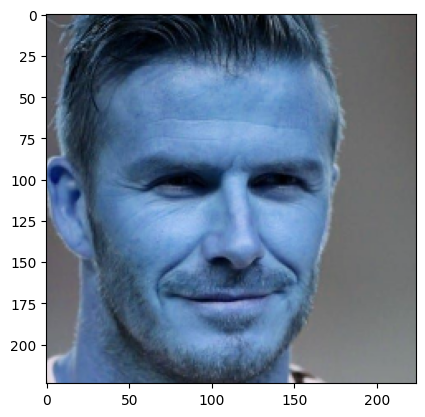

torch.Size([1, 3, 256, 256])


AssertionError: 

In [34]:
import torch
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm

from utils.inference.faceshifter_run import faceshifter_batch
from utils.inference.image_processing import crop_face, normalize_and_torch, normalize_and_torch_batch
from utils.inference.video_processing import read_video, crop_frames_and_get_transforms, resize_frames
from utils.inference.core import transform_target_to_torch

set_target = False
half=True
similarity_th=0.15


target_norm = normalize_and_torch_batch(np.array(target))
target_embeds = netArc(F.interpolate(target_norm, scale_factor=0.5, mode='bilinear', align_corners=True))

# Get the cropped faces from original frames and transformations to get those crops
crop_frames_list, tfm_array_list = crop_frames_and_get_transforms(full_frames, target_embeds, app, netArc, crop_size, set_target, similarity_th=similarity_th)

# Normalize source images and transform to torch and get Arcface embeddings
source_embeds = []
for source_curr in source:
    source_curr = normalize_and_torch(source_curr)
    source_embeds.append(netArc(F.interpolate(source_curr, scale_factor=0.5, mode='bilinear', align_corners=True)))

print(source_embeds[0].shape)

print(crop_frames_list[0][0].shape, crop_frames_list[0][0].dtype)

plt.imshow(crop_frames_list[0][0])
plt.show()

final_frames_list = []
for idx, (crop_frames, tfm_array, source_embed) in enumerate(zip(crop_frames_list, tfm_array_list, source_embeds)):
    # Resize croped frames and get vector which shows on which frames there were faces
    resized_frs, present = resize_frames(crop_frames)
    resized_frs = np.array(resized_frs)

    # transform embeds of Xs and target frames to use by model
    target_batch_rs = transform_target_to_torch(resized_frs, half=half)
    print(target_batch_rs.shape)
    #assert False
    if half:
        source_embed = source_embed.half()

    # run model
    size = target_batch_rs.shape[0]
    model_output = []

    for i in tqdm(range(0, size, BS)):
        Y_st = faceshifter_batch(source_embed, target_batch_rs[i:i+BS], G)
        model_output.append(Y_st)
    torch.cuda.empty_cache()
    model_output = np.concatenate(model_output)

    # create list of final frames with transformed faces
    final_frames = []
    idx_fs = 0

    for pres in tqdm(present):
        if pres == 1:
            final_frames.append(model_output[idx_fs])
            idx_fs += 1
        else:
            final_frames.append([])
    final_frames_list.append(final_frames)
    assert False
